In [20]:
import pandas as pd
import numpy as np
import shap

import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from statistics import mean, stdev

In [15]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F

In [21]:
from dataset import BldgDataset
from model import ClassificationModel

In [146]:
def main():
    model_name = 'model_full_19'
    os.makedirs(f'models/{model_name}', exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 8
    EPOCHS = 20
    lr = 5e-3
    l2_reg = 0.1
    dist_reg = None
    test_size = 0.2

    data = pd.read_csv('data/preprocessed.csv', header=0)

    test_df = data.sample(frac=test_size)
    train_df = data.drop(test_df.index)

    train_data = BldgDataset(train_df)
    test_data = BldgDataset(test_df)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)
    test_loader = DataLoader(test_data,
                             batch_size=batch_size*2,
                             shuffle=False)

    model = ClassificationModel(in_feats=train_data.num_feats(),
                                hidden_dim=10,
                                n_classes=train_data.num_classes(),
                                dropout=0.2,
                                activation='relu')
    optimizer = optim.Adam(model.parameters(),
                           lr=lr,
                           weight_decay=l2_reg)

    model.to(device)
    for epoch in range(EPOCHS):

        data_iter = tqdm(
            train_loader,
            desc=f'Epoch: {epoch:02}',
            total=len(train_loader)
        )

        model.train()
        avg_loss = 0.
        for i, (X, y) in enumerate(data_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            logits = model(X)

            # TODO: Find a loss function for ordinal classification. Try adding distance penalty for ordinality?
            loss = F.cross_entropy(logits, y)
            # y_one_hot = F.one_hot(y, num_classes=train_data.num_classes())
            # loss += dist_reg * F.mse_loss(logits, y_one_hot.float())

            if dist_reg is not None:
                y_one_hot = F.one_hot(y, num_classes=train_data.num_classes())
                pred_distance = torch.dist(logits, y_one_hot.float(), p=2)
                loss += dist_reg * pred_distance

            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            data_iter.set_postfix({
                'avg_loss': avg_loss / (i+1)
            })

    y_pred, y_true = [], []
    with torch.no_grad():
        model.eval()
        for X, y in test_loader:
            X = X.to(device)

            preds = torch.argmax(model(X), dim=-1)

            y_pred.extend(preds.cpu().tolist())
            y_true.extend(y.tolist())

    missed_pred, missed_true = [], []
    for y_p, y_t in zip(y_pred, y_true):
        if y_p != y_t:
            missed_pred.append(y_p)
            missed_true.append(y_t)

    acc = accuracy_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mae_missed = mean_absolute_error(missed_true, missed_pred)

    print(f'Test Accuracy: {acc:.4f}')
    print(f'Test MSE: {mse:.4f}')
    print(f'Test MAE: {mae:.4f}')
    print(f'Test Incorrect MAE: {mae_missed:.4f}')

#     torch.save(model.state_dict(), f'models/{model_name}/{model_name}_{trial:02d}.pt')
        
    batch = next(iter(train_loader))
    images, _ = batch
    batch2 = next(iter(test_loader))
    images2, _ = batch2
    
    train_shap = images.to(device)
    test_shap = images2.to(device)
         
    explainer = shap.DeepExplainer(model, train_shap)
    shap_values = explainer.shap_values(test_shap)
    
    return shap_values, test_loader

In [147]:
def ordinalize(x, n_classes=5):
    out = np.zeros(n_classes)
    for i in range(x):
        out[i] = 1
    return out

In [148]:
if __name__ == '__main__':
#     main()
    my_shap_values, target = main()

Epoch: 19: 100%|███████████████████████████████████████████████████████| 12/12 [00:00<00:00, 116.82it/s, avg_loss=1.24]


Test Accuracy: 0.6087
Test MSE: 1.2174
Test MAE: 0.6087
Test Incorrect MAE: 1.5556


In [149]:
import matplotlib.pyplot as plt

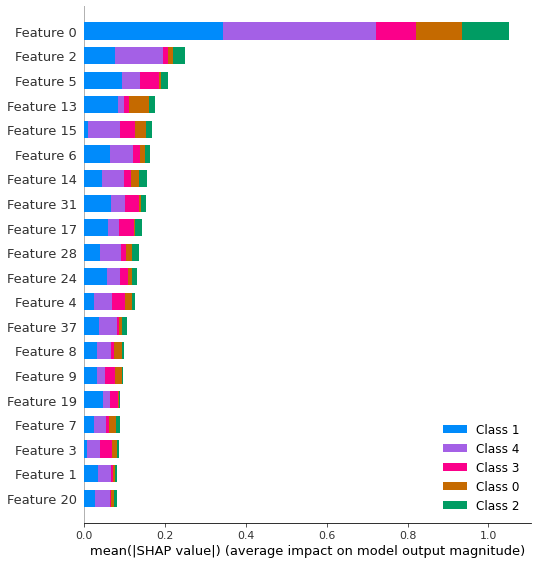

In [150]:
shap.summary_plot(my_shap_values, show=None)
plt.savefig('figures/deep_shap_impact_overall.png')

In [151]:
#taking the shape value only for the target class.
my_tar = []
for t in (list(target)[0][1]):
    my_tar.append(int(t))

true_shap = np.zeros((my_shap_values[0].shape[0], my_shap_values[0].shape[1]))

for i in range(len(my_tar)):
    ind = my_tar[i]
    temp_shap = my_shap_values[ind-1]
    true_shap[i,:] = temp_shap[i,:]

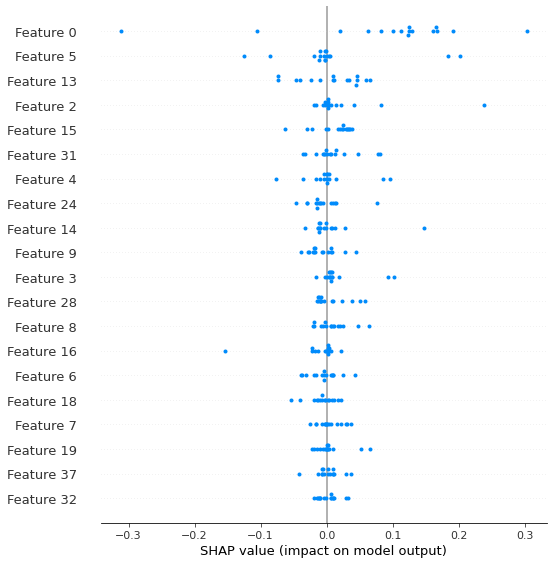

In [156]:
shap.summary_plot(true_shap, show=None)
plt.savefig('figures/deep_shap_impact.png')

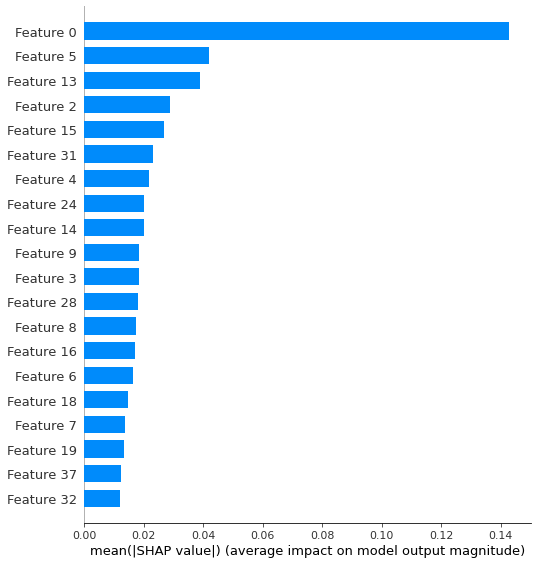

In [153]:
shap.summary_plot(true_shap, plot_type='bar', show=None)
plt.savefig('figures/deep_shap_contribution.png')

In [154]:
#Adding the shap value of one-hot encoded column
new_shap = np.zeros((16,27))

new_shap[:,:22] = true_shap[:,:22]
new_shap[:,22] = np.sum(true_shap[:,22:24], axis=1)
new_shap[:,23] = np.sum(true_shap[:,24:27], axis=1)
new_shap[:,24] = np.sum(true_shap[:,27:31], axis=1)
new_shap[:,25] = np.sum(true_shap[:,31:36], axis=1)
new_shap[:,26] = np.sum(true_shap[:,36:38], axis=1)

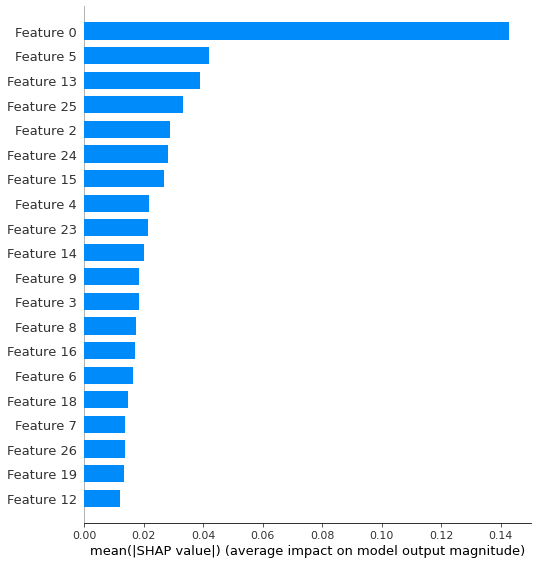

In [155]:
shap.summary_plot(new_shap, plot_type='bar', show=None)
plt.savefig('figures/deep_shap_contribution_exact.png')